# 构造微调训练数据集

借助 ChatGPT 和 GPT API 我们可以实现自动化批量构造训练数据集。

下面我们以中国古典哲学数据集为例，展示了自动构造训练集的主要流程：

- 使用 LangChain 构造训练数据样例
    - 基于 ChatGPT 设计 `System Role` 提示词
    - 使用 `OpenAI GPT-4o-mini` 生成基础数据
    - 解析 OpenAI GPT 生成的训练数据
    - 持久化存储`dataset.csv`训练数据集文件
    - 使用 ChatGPT 实现训练数据多样化
- 自动化批量生成训练数据集
    - 整理收集原始数据`raw_data.txt`
    - 自动解析原始数据样例 `raw_data_content[]`
    - 设计 `gen_data` 训练数据生成器函数
    - 设计训练数据生成流水线

最佳实践参考：

- 使用 GPT-4o-mini 生成基础数据：https://platform.openai.com/playground/p/2c7XNPgo6Y2iDxILiWfD3iPu?model=gpt-4o-mini&mode=chat
- 使用 ChatGPT 生成数据处理代码和相关文本整理：https://chat.openai.com/share/cdfd2d1d-a75e-4cee-be49-539c010ca1b1
- GPT API 价格: https://openai.com/pricing

## 使用 OpenAI SDk 构造训练数据

In [74]:
from openai import OpenAI
import os
from dotenv import load_dotenv
load_dotenv(override=True)

print(os.getenv("BASE_URL") )
print(os.getenv("API_KEY") )
print(os.getenv("MODEL_NAME") )


http://127.0.0.1:11434/v1
sk-9963bbb64f564279842a77ccfc9ae2df
qwen3:4b


In [75]:
client = OpenAI(api_key= os.getenv("API_KEY"), 
                base_url=os.getenv("BASE_URL")) # 初始化OpenAI客户端，使用API密钥和基础URL, 这里使用了qwen3的API

In [76]:
response = client.chat.completions.create(
  model=os.getenv("MODEL_NAME"),
  messages=[
    {     "role": "user",
      "content": "你好，请介绍你自己。不要输出思考过程内容。"  
    }
   ]
)

In [77]:
response.choices[0].message.content

'<think>\n嗯，用户让我介绍自己，但不要输出思考过程。首先，我需要回想一下自己的设定。我是通义千问，阿里巴巴集团旗下的大模型。要介绍清楚自己的身份、功能和特点，但不用写思考过程。\n\n用户可能想知道我是谁，能做什么，有什么特别之处。我需要用简洁明了的语言，避免技术术语太复杂。应该强调多语言支持、对话理解、代码写作、逻辑推理这些能力。还要提到应用场景，比如回答问题、创作文字、编程等。\n\n要确保不包含任何思考过程的内容，所以直接从介绍开始。可能用户是想快速了解我的能力，或者想测试我的回应是否符合要求。可能需要避免使用Markdown格式，保持纯文本。检查有没有多余的信息，比如不需要提训练数据截止时间，除非用户特别问到。\n\n对了，用户说“不要输出思考过程内容”，所以我要确保回答是直接的介绍，没有解释为什么这样回答。可能用户之前遇到过AI输出思考过程，所以这次要严格避免。需要保持回答简短，但信息完整。\n\n开始组织语言：先说名字，所属公司，然后主要功能，再举几个例子，最后提一下应用场景。比如：“你好！我是通义千问，阿里巴巴集团旗下的超大规模语言模型。我能够回答问题、创作文字、编程、逻辑推理，支持多语言交流。例如，你可以让我写故事、写公文、写邮件、写剧本，或者表达观点、玩游戏等。如果你有任何问题，欢迎随时问我！”\n\n这样应该符合要求，没有思考过程，结构清晰。检查是否有冗余，比如“超大规模”可能可以简化为“大模型”或者“超大”，但可能用户需要知道是超大规模的。不过原话中的“超大规模”可能没问题。再想想，可能“超大规模语言模型”是标准说法，所以保留。\n\n确认没有使用任何markdown，纯文本。最后加上欢迎语，让回答更友好。没问题的话就输出这个。\n</think>\n\n你好！我是通义千问，阿里巴巴集团旗下的超大规模语言模型。我能够回答问题、创作文字、编程、逻辑推理，支持多语言交流。例如，你可以让我写故事、写公文、写邮件、写剧本，或者表达观点、玩游戏等。如果你有任何问题，欢迎随时问我！'

In [78]:
response = client.chat.completions.create(
  model=os.getenv("MODEL_NAME"),
  messages=[
    {
      "role": "system",
      "content": "你是中国古典哲学大师，尤其擅长周易的哲学解读。\n\n接下来，你收到的都是关于周易卦象的解释，你需要整理润色，并生成用于大模型训练的内容和格式。\n\n示例输入：\n\n师卦，此卦是异卦相叠，下卦为坎，上卦为坤。“师”指军队。坎为水、为险；坤为地、为顺，喻寓兵于农。兵凶战危，用兵乃圣人不得已而为之，但它可以顺利无阻碍地解决矛盾，因为顺乎形势，师出有名，故能化凶为吉。占得此卦，对于军事上率师出征非常有利，必无灾祸。师卦是天马出群之卦，以寡伏众之象。\n师卦位于讼卦之后，《序卦》之中这样解释道：“讼必有众起，故受之以师。师者，众也。”争讼的人越来越多，以致形成了军队。\n\n期待结果：\n\ncontent:\"师卦\"\nsummary:\"在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。\n\n师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。\n\n师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。输出内容不要包含思考过程。\""
    },
    {
      "role": "user",
      "content": "蒙卦是教育启蒙的智慧，艮为山，坎为泉，山下出泉。泉水始流出山，则必将渐汇成江河,正如蒙稚渐启，又山下有险，因为有险停止不前，所以蒙昧不明。事物发展的初期阶段，必然蒙昧，所以教育是当务之急，养学生纯正无邪的品质，是治蒙之道。\n蒙卦，这个卦是异卦相叠，下卦为坎，上卦为艮。艮是山的形象，喻止；坎是水的形象，喻险。卦形为山下有险，仍不停止前进，是为蒙昧，故称蒙卦。但因把握时机，行动切合时宜;因此，具有启蒙和通达的卦象。\n《蒙》卦是《屯》卦这个始生卦之后的第二卦。《序卦》中说：“物生必蒙，故受之以蒙。蒙者，蒙也，特之稚也。”物之幼稚阶段，有如蒙昧未开的状态，在人则是指童蒙。\n《象》中这样解释蒙卦：山下出泉，蒙；君子以果行育德。"
    },
    {
      "role": "assistant",
      "content": "content:\"蒙卦\"\nsummary:\"在周易中，蒙卦象征着教育启蒙和智慧的初期阶段，由两个异卦相叠组成：下卦坎（水）和上卦艮（山）。坎象征水，艮象征山，代表了山下有水源，水流出山。这预示着在事物发展的起初阶段，人们会陷入蒙昧状态，因此教育成为当务之急。只有培养纯正无邪的品质，才能走上通达之路，如同泉水汇成江河。\n\n蒙卦的核心哲学是：事物发展的初期阶段必然处于蒙昧状态，但如果能把握时机，行动切合时宜，就能启蒙通达。蒙卦紧随始生卦《屯》之后，《序卦》中解释道：“物生必蒙，故受之以蒙。蒙者，蒙也，特之稚也。”这说明物在幼稚阶段都会经历蒙昧状态，找它蒙即是稚嫩。\n\n《象》中解释说：山下出泉，蒙；君子以果行育德，意味着像泉水从山下流出一样，启蒙教育有助于培育美德。输出内容不要包含思考过程。\""
    },
    {
      "role": "user",
      "content": "需卦，本卦是异卦相叠，上卦为坎，下卦为乾。乾卦象征天空辽阔，坎卦象征乌云密布。雨水之于传统农业社会而言，是最大的需求，因此用这个意象来表现。古人引申为雨将下，万物皆待，所以叫需。\n需，古体字结构是“雨上天下”，从雨而声。如苍天下雨，滋养万物及人。从人的角度看，天下雨，则不易出行耕作，因此在家喝酒吃肉、静待天时。所以，这一卦的基本象征就是等待、不进，还有饮食之义。\n \n需卦位于蒙卦之后，《序卦》之中这样解释道：“物稚不可不养也，故受之以需。需者，饮食之道也。”有所需要，也是有所等待。\n《象》曰：云上于天，需;君子以饮食宴乐。\n《象》中这段话的意思是说：需卦的卦象是乾(天)下坎(水)上，为水在天上之表象。水汽聚集天上成为云层，密云満天，但还没有下雨，需要等待;君子在这个时候需要吃喝，饮酒作乐，即在等待的时候积蓄力量。\n需卦象征等待，启示人们守正待机的道理，属于中上卦。《象》这样评断此卦：明珠土埋日久深，无光无亮到如今，忽然大风吹土去，自然显露有重新。\n"
    },
    {
      "role": "assistant",
      "content": "content:\"需卦\"\nsummary:\"在周易中，需卦是一个富有深意的卦象，由两个异卦相叠组成：下卦乾（天）和上卦坎（水）。乾象征广阔的天空，而坎象征乌云密布，暗示着迫切需要雨水的意象。古人将雨水视为万物生长的必需，因此命名为“需”。需卦的基本象征是等待和饮食之道。\n\n需卦位于蒙卦之后，《序卦》中解释为“物稚不可不养也，故受之以需。需者，饮食之道也。”说明物在幼稚状态需要得到滋养，因此受到需卦的启示。《象》中描述：云上于天，需；君子以饮食宴乐。意味着天空乌云密布，需要等待雨水，而君子则在等待的过程中积蓄力量，享受饮食和欢乐。\n\n需卦的核心哲学是：等待，启示着守正待机的道理。它属于中上卦，象征着埋藏已久的明珠，经过大风吹去尘埃后，重新显露光芒。输出内容不要包含思考过程。\""
    }
  ],
  temperature=1,
  max_tokens=4095,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

---

## 使用 LangChain 构造训练数据

In [79]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)

chat = ChatOpenAI(model=os.getenv("MODEL_NAME"),
                  api_key=os.getenv("API_KEY"),
                  base_url=os.getenv("BASE_URL"),
                  temperature=1,
                  max_tokens=4095)

In [80]:
system_content = """
你是中国古典哲学大师，尤其擅长周易的哲学解读。

接下来，你收到的都是关于周易卦象的解释，你需要整理润色，并生成用于大模型训练的内容和格式。

示例输入：

师卦，此卦是异卦相叠，下卦为坎，上卦为坤。“师”指军队。坎为水、为险；坤为地、为顺，喻寓兵于农。兵凶战危，用兵乃圣人不得已而为之，但它可以顺利无阻碍地解决矛盾，因为顺乎形势，师出有名，故能化凶为吉。占得此卦，对于军事上率师出征非常有利，必无灾祸。师卦是天马出群之卦，以寡伏众之象。
师卦位于讼卦之后，《序卦》之中这样解释道：“讼必有众起，故受之以师。师者，众也。”争讼的人越来越多，以致形成了军队。

期待结果：

content:"师卦"
summary:"在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。

师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。

师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。"

请输出内容不要包含思考过程。
"""


In [81]:
# 原始数据
raw_content = "蒙卦是教育启蒙的智慧，艮为山，坎为泉，山下出泉。泉水始流出山，则必将渐汇成江河,正如蒙稚渐启，又山下有险，因为有险停止不前，所以蒙昧不明。事物发展的初期阶段，必然蒙昧，所以教育是当务之急，养学生纯正无邪的品质，是治蒙之道。\n蒙卦，这个卦是异卦相叠，下卦为坎，上卦为艮。艮是山的形象，喻止；坎是水的形象，喻险。卦形为山下有险，仍不停止前进，是为蒙昧，故称蒙卦。但因把握时机，行动切合时宜;因此，具有启蒙和通达的卦象。\n《蒙》卦是《屯》卦这个始生卦之后的第二卦。《序卦》中说：“物生必蒙，故受之以蒙。蒙者，蒙也，特之稚也。”物之幼稚阶段，有如蒙昧未开的状态，在人则是指童蒙。\n《象》中这样解释蒙卦：山下出泉，蒙；君子以果行育德。"

In [82]:
messages = [
    SystemMessage(
        content=system_content
    ),
    HumanMessage(
        content=raw_content
    ),
]

In [83]:
ai_message = chat(messages)

### 解析 OpenAI GPT 生成的训练数据

In [84]:
ai_message.content

'<think>\n首先，用户要求我作为中国古典哲学大师，尤其擅长周易的哲学解读。我需要整理润色输入的文本，并生成用于大模型训练的内容和格式。输出的格式是：content:"..." 和 summary:"..."，不要包含思考过程。\n\n输入的文本是关于蒙卦的：\n\n"蒙卦是教育启蒙的智慧，艮为山，坎为泉，山下出泉。泉水始流出山，则必将渐汇成江河,正如蒙稚渐启，又山下有险，因为有险停止不前，所以蒙昧不明。事物发展的初期阶段，必然蒙昧，所以教育是当务之急，养学生纯正无邪的品质，是治蒙之道。\n蒙卦，这个卦是异卦相叠，下卦为坎，上卦为艮。艮是山的形象，喻止；坎是水的形象，喻险。卦形为山下有险，仍不停止前进，是为蒙昧，故称蒙卦。但因把握时机，行动切合时宜;因此，具有启蒙和通达的卦象。\n《蒙》卦是《屯》卦这个始生卦之后的第二卦。《序卦》中说：“物生必蒙，故受之以蒙。蒙者，蒙也，特之稚也。”物之幼稚阶段，有如蒙昧未开的状态，在人则是指童蒙。\n《象》中这样解释蒙卦：山下出泉，蒙；君子以果行育德。"\n\n参考示例输出：对于师卦，content是"师卦"，summary是详细描述。在示例中，summary是：在周易中，...（具体描述）。\n\n所以，我需要：\n\n1. 提取核心内容：蒙卦的解读。\n\n2. 润色：使语言更流畅、专业、符合周易哲学；避免重复；逻辑清晰。\n\n3. 组织为content和summary。\n\ncontent 应该是简洁的卦名，如 "蒙卦"。\n\nsummary 是详细的哲学解读，类似示例。\n\n结构化summary：\n\n- 介绍蒙卦：异卦相叠，下坎上艮。\n\n- 解释卦象：山（艮）下有泉（坎），泉水初流出山，象征启蒙。\n\n- 哲学含义：蒙昧状态，教育的重要性；物之幼稚，需启蒙。\n\n- 引用《序卦》和《象》：物生必蒙，君子以果行育德。\n\n润色点：\n\n- 避免冗长重复：输入中提到"蒙卦是教育启蒙的智慧"，但后面说"卦形为山下有险"，等。\n\n- 用更专业的语言：例如，"泉水始流出山" -> "初生之泉自山而出"。\n\n- 逻辑流：从卦象到哲学意义，再到实践。\n\n- 包含关键点：蒙卦是《屯》卦之后的第二卦；《序卦》解释；《象》中"君子以果行育德"。\n\n目标output：\n\ncontent:"蒙卦"

In [85]:
text = ai_message.content

# 分割字符串来找到content和summary的位置
content_start = text.find('content:"') + len('content:"')
content_end = text.find('"\nsummary:')
summary_start = text.find('summary:"') + len('summary:"')
summary_end = text.rfind('"')

# 提取并存储content和summary
content = text[content_start:content_end].strip()
summary = text[summary_start:summary_end].strip()

print("Content:", content)
print("Summary:", summary)


Content: ..." 和 summary:"..."，不要包含思考过程。

输入的文本是关于蒙卦的：

"蒙卦是教育启蒙的智慧，艮为山，坎为泉，山下出泉。泉水始流出山，则必将渐汇成江河,正如蒙稚渐启，又山下有险，因为有险停止不前，所以蒙昧不明。事物发展的初期阶段，必然蒙昧，所以教育是当务之急，养学生纯正无邪的品质，是治蒙之道。
蒙卦，这个卦是异卦相叠，下卦为坎，上卦为艮。艮是山的形象，喻止；坎是水的形象，喻险。卦形为山下有险，仍不停止前进，是为蒙昧，故称蒙卦。但因把握时机，行动切合时宜;因此，具有启蒙和通达的卦象。
《蒙》卦是《屯》卦这个始生卦之后的第二卦。《序卦》中说：“物生必蒙，故受之以蒙。蒙者，蒙也，特之稚也。”物之幼稚阶段，有如蒙昧未开的状态，在人则是指童蒙。
《象》中这样解释蒙卦：山下出泉，蒙；君子以果行育德。"

参考示例输出：对于师卦，content是"师卦"，summary是详细描述。在示例中，summary是：在周易中，...（具体描述）。

所以，我需要：

1. 提取核心内容：蒙卦的解读。

2. 润色：使语言更流畅、专业、符合周易哲学；避免重复；逻辑清晰。

3. 组织为content和summary。

content 应该是简洁的卦名，如 "蒙卦"。

summary 是详细的哲学解读，类似示例。

结构化summary：

- 介绍蒙卦：异卦相叠，下坎上艮。

- 解释卦象：山（艮）下有泉（坎），泉水初流出山，象征启蒙。

- 哲学含义：蒙昧状态，教育的重要性；物之幼稚，需启蒙。

- 引用《序卦》和《象》：物生必蒙，君子以果行育德。

润色点：

- 避免冗长重复：输入中提到"蒙卦是教育启蒙的智慧"，但后面说"卦形为山下有险"，等。

- 用更专业的语言：例如，"泉水始流出山" -> "初生之泉自山而出"。

- 逻辑流：从卦象到哲学意义，再到实践。

- 包含关键点：蒙卦是《屯》卦之后的第二卦；《序卦》解释；《象》中"君子以果行育德"。

目标output：

content:"蒙卦"

summary:"在周易中，蒙卦是一个深邃的卦象，它由两个异卦相叠构成：下卦为坎（水），上卦为艮（山）。这一卦象象征着“蒙”，即启蒙，寓意着初生之泉自山而出，逐步汇流成江河，正如童蒙之渐启。山下有险，象征着初期的蒙昧与障碍，但事物在发展之初必

### 持久化存储训练数据集文件

In [86]:
import csv

# 如果没有GPT API，可以使用预定义的变量
# content = "蒙卦"
# summary = "在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。"

# 新建CSV文件并写入数据
with open('test_dataset.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # 写入标题行
    writer.writerow(['content', 'summary'])
    # 写入数据行
    writer.writerow([content, summary])


### 数据增强：构造多样化的提问方式

In [87]:
def generate_question_summary_pairs(content, summary):
    """
    生成20对提问和总结的配对。

    :param content: 内容（例如：“蒙卦”）。
    :param summary: 内容的总结。
    :return: 包含20对提问和总结的列表。
    """
    # 20种提问模板
    question_templates = [
        "{}代表什么？",
        "周易中的{}含义是什么？",
        "请解释一下{}。",
        "{}在周易中是什么象征？",
        "周易{}的深层含义是什么？",
        "{}和教育启蒙有什么联系？",
        "周易的{}讲述了什么？",
        "{}是怎样的一个卦象？",
        "{}在周易中怎样表达教育的概念？",
        "{}的基本意义是什么？",
        "周易中{}的解释是什么？",
        "{}在周易中代表了哪些方面？",
        "{}涉及哪些哲学思想？",
        "周易中{}的象征意义是什么？",
        "{}的主要讲述内容是什么？",
        "周易{}的核心思想是什么？",
        "{}和启蒙教育之间有何联系？",
        "在周易中，{}象征着什么？",
        "请描述{}的含义。",
        "{}在周易哲学中扮演什么角色？"
    ]

    # 使用content填充提问模板
    questions = [template.format(content) for template in question_templates]

    # 创建提问和总结的配对
    question_summary_pairs = [(question, summary) for question in questions]

    return question_summary_pairs

In [88]:
import csv

# 如果没有GPT API，可以使用预定义的变量
# content = "蒙卦"
# summary = "在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。"
pairs = generate_question_summary_pairs(content, summary)

# 将结果写入CSV文件
with open('test_dataset.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['content', 'summary'])
    for pair in pairs:
        writer.writerow(pair)


## 自动化批量生成训练数据流水线

原始数据来源：https://www.zhouyi.cc/zhouyi/yijing64/4103.html

In [89]:
# 初始化一个空列表用于存储原始内容数据
raw_content_data = []

# 读取文件并分割数据样例
with open('data/raw_data.txt', 'r', encoding='utf-8') as file:
    content = file.read()
    # 使用连续的换行符('\n\n')作为分隔符来分割文本
    data_samples = content.split('\n\n')

    # 遍历分割后的数据样例并添加到列表中
    for sample in data_samples:
        # 移除每个样例中的额外空白字符（如果有的话）
        cleaned_sample = sample.strip()
        # 仅添加非空样例
        if cleaned_sample:
            raw_content_data.append(cleaned_sample)

In [90]:
# 输出结果以验证
for i, sample in enumerate(raw_content_data[:5]):  # 打印前5个样例以检查
    print(f"样例 {i+1}:")
    print(sample)
    print("------")


样例 1:
蒙卦原文
蒙。亨。匪我求童蒙，童蒙求我。初筮告，再三渎，渎则不告。利贞。
象曰：山下出泉，蒙。君子以果行育德。
白话文解释
蒙卦：通泰。不是我有求于幼稚愚昧的人，而是幼稚愚昧的人有求于我。第一次占筮，神灵告诉了他。轻慢不敬的再三占筮，轻慢不敬的占筮，神灵就不会告诉他。但还是吉利的卜问。
《象辞》说：上卦为艮，象征山；下卦为坎，象征泉。山下有泉，泉水喷涌而出，这是蒙卦的卦象。君子观此卦象，取法于一往无前的山泉，从而以果敢坚毅的行动来培养自身的品德。
《断易天机》解
蒙卦艮上坎下，为离宫四世卦。蒙即蒙昧，主回还往复，疑惑不前，多忧愁过失，乃是凶卦。
北宋易学家邵雍解
智慧未开，蒙昧闭塞；犹豫不决，缺乏果断。
得此卦者，智慧犹如童蒙，不辨是非，迷失方向；若能顺贤师良友之教，启其聪明则亨通。
台湾国学大儒傅佩荣解
时运：蓄积德行，出而用世。
财运：矿山生意，果决则吉。
家宅：君子居吉；婚姻之始。
身体：驱去邪热，可保平安。
传统解卦
这个卦是异卦（下坎上艮）相叠，艮是山的形象，喻止；坎是水的形象，喻险。卦形为山下有险，仍不停止前进，是为蒙昧，故称蒙卦。但因把握时机，行动切合时宜，因此，具有启蒙和通达的卦象。
大象：蒙者，昏而无所见也，故宜「启蒙」。
运势：初时迷惑不知方向，须忍耐待机而动，凡事多听取别人意见，则运可通。
事业：事业开始，混乱无序，危机四伏，以勇敢坚毅的行动可以扭转局面。然而必须接受严格教育，培养这种奋发图强的精神。务必脚踏实地，最忌好高骛远，否则会陷入孤立无援的境地。
经商：务必小心谨慎，不得急功近利，尤其应树立高尚的商业道德，以良好的信誉提高竞争力而取胜。
求名：必须接受良好的基础教育，陶冶情操。且动机纯正，可以达到目的。
婚恋：注意考察对方品德，不可以金钱为诱铒。夫妻需相互宽容、理解。
决策：有时会陷入迷惘困顿的境地，加上胆小、不果断，往往误事。如能接受长辈的教诲，甚至严酷的考验，抛弃疑惧的心理，等待适当时机，必然一帆风顺。
------
样例 2:
屯卦原文
屯。元，亨，利，贞。勿用，有攸往，利建侯。
象曰：云，雷，屯；君子以经纶。
白话文解释
屯卦。大吉大利，吉利的占卜。不利于出门。有利于建国封侯。
《象辞》说：屯的上卦为坎，坎为云，下卦为震，震为雷。云行于上，雷动于下，是屯卦的卦象。君子观此卦象，取法于云雷，用云的恩泽，雷的威严来治理国

### 将以上的所有模块，整合到一起，自动化生成数据

In [91]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)

# 初始化LangChain的GPT-4o-mini调用
chat = ChatOpenAI(model=os.getenv("MODEL_NAME"),
                  api_key=os.getenv("API_KEY"),
                  base_url=os.getenv("BASE_URL"),
                  temperature=1,
                  max_tokens=4095)

def gen_data(raw_content):
    """
    使用LangChain GPT-4o-mini调用处理单个数据样例。

    :param raw_content: 原始数据样例。
    :return: GPT-4o-mini模型生成的内容。
    """
    # 系统消息定义背景和任务
    system_message = SystemMessage(
        content="""
        你是中国古典哲学大师，尤其擅长周易的哲学解读。

        接下来，你收到的都是关于周易卦象的解释，你需要整理润色，并生成用于大模型训练的内容和格式。

        示例输入：

        师卦，此卦是异卦相叠，下卦为坎，上卦为坤。“师”指军队。坎为水、为险；坤为地、为顺，喻寓兵于农。兵凶战危，用兵乃圣人不得已而为之，但它可以顺利无阻碍地解决矛盾，因为顺乎形势，师出有名，故能化凶为吉。占得此卦，对于军事上率师出征非常有利，必无灾祸。师卦是天马出群之卦，以寡伏众之象。
        师卦位于讼卦之后，《序卦》之中这样解释道：“讼必有众起，故受之以师。师者，众也。”争讼的人越来越多，以致形成了军队。

        期待结果：

        content:"师卦"
        summary:"在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。

        师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。

        师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。"
        """
    )

    # 人类消息包含原始数据样例
    human_message = HumanMessage(
        content=raw_content
    )

    # 构建消息列表并进行模型调用
    messages = [system_message, human_message]
    ai_message = chat(messages)

    return ai_message.content

In [92]:
# 示例调用（使用 raw_data.txt 中解析的数据样例）
generated_content = gen_data(raw_content_data[0])
print(generated_content)

<think>
首先，用户要求我作为中国古典哲学大师，尤其擅长周易的哲学解读。我需要整理润色他们提供的蒙卦相关的内容，并生成用于大模型训练的内容和格式。

用户提供的输入包括：
- 蒙卦原文
- 白话文解释
- 《断易天》解（这里应该是《断易天机》解，但用户写的是《断易天机》解）
- 北宋易学家邵雍解
- 台湾国学大儒傅佩荣解
- 传统解卦（包括大象、运势、事业、经商、求名、婚恋、决策等）

期待结果的格式是：
content:"师卦"
summary:"..."

在示例中，对于师卦，content是卦名，summary是详细的哲学解读。我需要为蒙卦生成类似的content和summary。

关键点：
- content: 应该是卦名，这里是"蒙卦"
- summary: 一段连贯、润色后的文字，基于提供的所有信息，突出周易哲学解读。要简洁、有深度，适合大模型训练。

我的任务：
1. **整理润色**：从用户输入中提取关键信息，去除冗余，语言要流畅、专业、符合周易哲学。避免直接复制粘贴；要重写成自然的中文。
2. **生成内容**：content字段是卦名（"蒙卦"）；summary字段是描述性的文本。
3. **符合大模型训练**：内容要结构化、信息丰富、语言规范。summary应该覆盖核心哲学、卦象解释、实际应用（如运势、事业等），但要精炼。避免太长的段落；示例中summary约200-300字。

从用户输入中提取核心点：
- **卦象**：蒙卦是异卦，下坎上艮（水在上？等一下，标准是坎下艮上？不，蒙卦是上艮下坎？等下，周易中蒙卦是下坎上艮？我需要确认。）
  - 在用户输入中："蒙卦艮上坎下" – 所以是上艮下坎（艮是山，坎是水）。卦象：山下有泉。
- **原文**：蒙。亨。匪我求童蒙，童蒙求我。初筮告，再三渎，渎则不告。利贞。
- **白话文解释**：通泰；不是我有求于幼稚愚昧的人，而是幼稚愚昧的人有求于我；占筮时，第一次就告诉，再三轻慢就不告；但吉利。
- **《象辞》**：山下出泉，蒙。君子以果行育德。
- **邵雍解**：智慧未开，蒙昧闭塞；犹豫不决，缺乏果断。得此卦者，智慧如童蒙，需师友启蒙。
- **傅佩荣解**：时运（蓄积德行，出而用世）、财运（矿山生意，果决则吉）、家宅（君子居吉）、婚姻（始）、身体（驱邪热，平安）。
- **传统解卦*

In [93]:
def dataset_parser(ai_message_content):
    """
    解析由gen_data函数生成的ai_message.content，提取content和summary。

    :param ai_message_content: gen_data函数返回的文本。
    :return: 提取的content和summary。
    """
    # 分割字符串来找到content和summary的位置
    content_start = ai_message_content.find('content:"') + len('content:"')
    content_end = ai_message_content.find('"\nsummary:')
    summary_start = ai_message_content.find('summary:"') + len('summary:"')
    summary_end = ai_message_content.rfind('"')

    # 提取并存储content和summary
    content = ai_message_content[content_start:content_end].strip()
    summary = ai_message_content[summary_start:summary_end].strip()

    return content, summary


In [94]:
# 示例调用（使用假设的gen_data函数返回的文本）
content, summary = dataset_parser(generated_content)
print("Content:", content)
print("Summary:", summary)

Content: 师卦
Summary: ..."

在示例中，对于师卦，content是卦名，summary是详细的哲学解读。我需要为蒙卦生成类似的content和summary。

关键点：
- content: 应该是卦名，这里是"蒙卦"
- summary: 一段连贯、润色后的文字，基于提供的所有信息，突出周易哲学解读。要简洁、有深度，适合大模型训练。

我的任务：
1. **整理润色**：从用户输入中提取关键信息，去除冗余，语言要流畅、专业、符合周易哲学。避免直接复制粘贴；要重写成自然的中文。
2. **生成内容**：content字段是卦名（"蒙卦"）；summary字段是描述性的文本。
3. **符合大模型训练**：内容要结构化、信息丰富、语言规范。summary应该覆盖核心哲学、卦象解释、实际应用（如运势、事业等），但要精炼。避免太长的段落；示例中summary约200-300字。

从用户输入中提取核心点：
- **卦象**：蒙卦是异卦，下坎上艮（水在上？等一下，标准是坎下艮上？不，蒙卦是上艮下坎？等下，周易中蒙卦是下坎上艮？我需要确认。）
  - 在用户输入中："蒙卦艮上坎下" – 所以是上艮下坎（艮是山，坎是水）。卦象：山下有泉。
- **原文**：蒙。亨。匪我求童蒙，童蒙求我。初筮告，再三渎，渎则不告。利贞。
- **白话文解释**：通泰；不是我有求于幼稚愚昧的人，而是幼稚愚昧的人有求于我；占筮时，第一次就告诉，再三轻慢就不告；但吉利。
- **《象辞》**：山下出泉，蒙。君子以果行育德。
- **邵雍解**：智慧未开，蒙昧闭塞；犹豫不决，缺乏果断。得此卦者，智慧如童蒙，需师友启蒙。
- **傅佩荣解**：时运（蓄积德行，出而用世）、财运（矿山生意，果决则吉）、家宅（君子居吉）、婚姻（始）、身体（驱邪热，平安）。
- **传统解卦**：卦形为山下有水，喻蒙昧；启蒙通达；运势：初时迷惑，需待机；事业：开始混乱，需勇敢行动；经商：谨慎；求名：基础教育；婚恋：考察品德；决策：需听取意见。

润色要点：
- 保持周易的哲学深度：强调启蒙、教育、德行。
- 语言要优美、简洁，避免口语化。
- 结构：先总述卦象，再哲学含义，再实际应用（但要提炼，不罗列）。
- 避免直接引用原文；用白话再诠释。
- 字数：参考示例，summary约150-250字。

脑

In [95]:
import csv
import datetime
import os

def main():
    # 确保 data 目录存在
    if not os.path.exists('data'):
        os.makedirs('data')

    # 解析 data/raw_data.txt 得到 raw_content_data 列表
    raw_content_data = []
    with open('data/raw_data.txt', 'r', encoding='utf-8') as file:
        content = file.read()
        data_samples = content.split('\n\n')
        for sample in data_samples:
            cleaned_sample = sample.strip()
            if cleaned_sample:
                raw_content_data.append(cleaned_sample)

    # 创建带有时间戳的CSV文件名
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"data/zhouyi_dataset_{timestamp}.csv"

    # 创建CSV文件并写入标题行
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['content', 'summary'])

        # 循环遍历 raw_content_data 数据样例
        for raw_content in raw_content_data:
            # 调用 gen_data 方法得到 ai_message_content
            ai_message_content = gen_data(raw_content)

            # 解析 ai_message_content 得到 content 和 summary
            content, summary = dataset_parser(ai_message_content)
            
            print("Content:", content)
            print("Summary:", summary)

            # 调用 generate_question_summary_pairs 得到20组 pairs
            pairs = generate_question_summary_pairs(content, summary)

            # 将 pairs 写入 csv 文件
            for pair in pairs:
                writer.writerow(pair)


In [97]:
# 执行主函数
main()

KeyboardInterrupt: 

#### 本地模型运行时，Ollama利用了GPU算力和显存

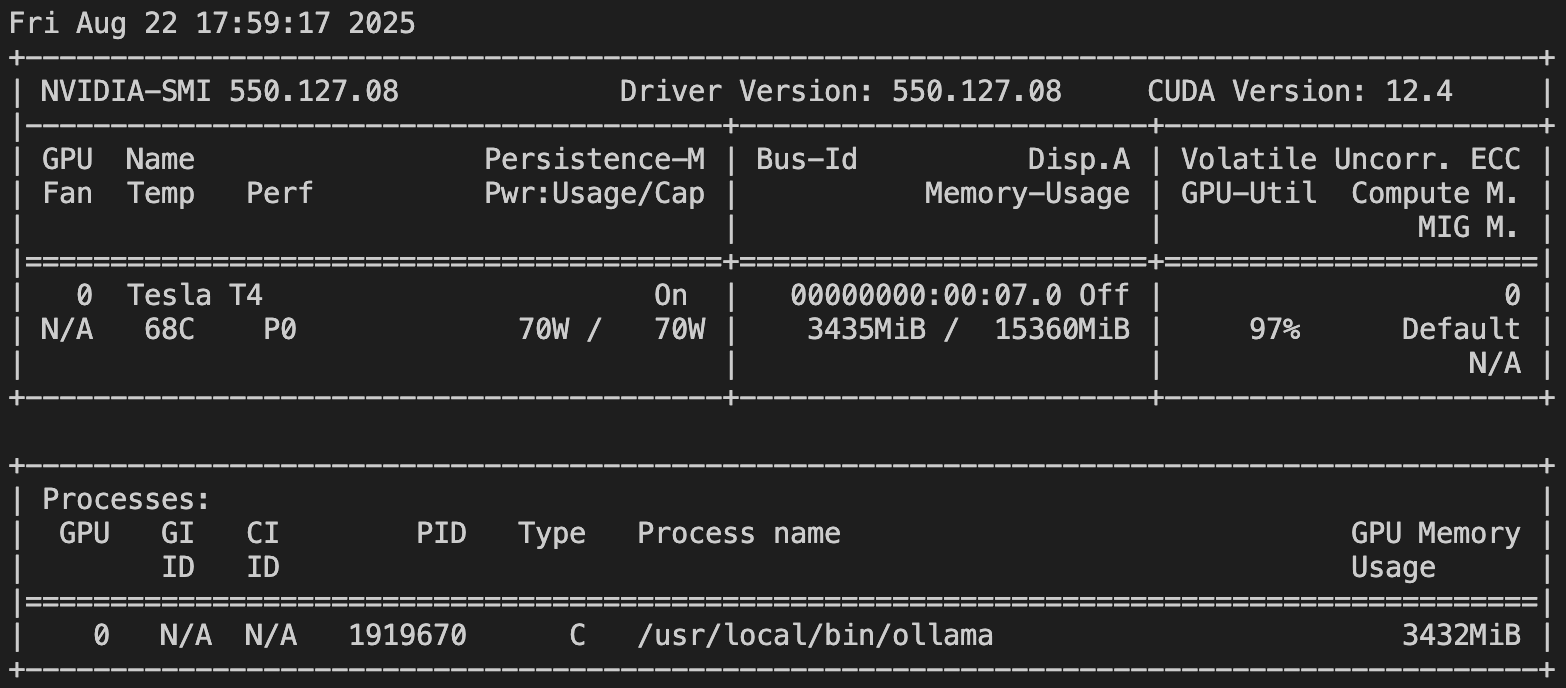

### 异常分析


训练第一个 epoch 时，Training Loss 比较奇怪：

```
Step	Training Loss
1	3.594100
2	4.049100
3	3.091200
4	3.381700
5	3.547800
6	2.610200
7	2.657900
8	3.163900
```

通过解析 gpt-4o-mini 生成结果发现问题

In [63]:
def gen_data(raw_content):
    """
    使用LangChain qwen3:4b调用处理单个数据样例。

    :param raw_content: 原始数据样例。
    :return: qwen3:4b模型生成的内容。
    """
    # 系统消息定义背景和任务
    system_message = SystemMessage(
        content="""
        你是中国古典哲学大师，尤其擅长周易的哲学解读。

        接下来，你收到的都是关于周易卦象的解释，你需要整理润色，并生成用于大模型训练的内容和格式。

        示例输入：

        师卦，此卦是异卦相叠，下卦为坎，上卦为坤。“师”指军队。坎为水、为险；坤为地、为顺，喻寓兵于农。兵凶战危，用兵乃圣人不得已而为之，但它可以顺利无阻碍地解决矛盾，因为顺乎形势，师出有名，故能化凶为吉。占得此卦，对于军事上率师出征非常有利，必无灾祸。师卦是天马出群之卦，以寡伏众之象。
        师卦位于讼卦之后，《序卦》之中这样解释道：“讼必有众起，故受之以师。师者，众也。”争讼的人越来越多，以致形成了军队。

        期待结果：

        content:"师卦"
        summary:"在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。

        师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。

        师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。"

        返回格式要求：
        content:"{卦名}"
        summary:"{内容}"
        """
    )

    # 人类消息包含原始数据样例
    human_message = HumanMessage(
        content=raw_content
    )

    # 构建消息列表并进行模型调用
    messages = [system_message, human_message]
    ai_message = chat(messages)

    return ai_message.content

In [64]:
# 执行主函数
main()

Content: {卦名}"

summary:"{内容}"

用户提供的信息包括：

- 蒙卦原文

- 白话文解释

- 《象辞》说

- 《断易天.天机》解

- 北宋易学家邵雍解

- 台湾国学大儒傅佩荣解

- 传统解卦

我需要将这些信息整理成一个流畅、专业的summary，突出蒙卦的哲学解读。重点是周易的哲学解读，所以要强调深意、寓意、核心思想。

回顾示例：对于师卦，summary包含卦象组成、含义、核心哲学、与前卦的关系等。结构是：

- 介绍卦名和组成

- 解释卦象的象征意义

- 核心哲学思想

- 与前后卦的关系（如有）

- 现实应用（如军事、占卜等）

对于蒙卦，我需要提取关键点：

1. **卦象组成**：下卦坎（水），上卦艮（山）→ 蒙卦（山下有泉）

2. **核心含义**：启蒙、蒙昧、初始阶段

3. **白话文解释**：通泰；不是我有求于幼稚，而是幼稚有求于我；占筮的规则：初筮告，再三渎则不告；利贞。

4. **《象辞》**：山下出泉，蒙。君子以果行育德。

5. **邵雍解**：智慧未开，蒙昧闭塞；犹豫不决，缺乏果断。

6. **傅佩荣解**：时运、财运、家宅、身体等

7. **传统解卦**：异卦相叠，山下有险，不停止前进；启蒙和通达；初时迷惑，须忍耐待机；事业、经商、求名、婚恋等。

目标是生成一个简洁、专业的summary，避免冗长。聚焦于哲学层面，而不是具体应用（如财运、婚恋），因为示例中师卦的summary没有这么细的条目，而是更哲学化。

从示例中，summary是：

- 在周易中，师卦是一个极具深意的卦象...

- 由两个异卦相叠组成...

- 解释卦象的象征意义

- 核心哲学

- 与讼卦的关系

对于蒙卦，可以这样结构化：

- 开头：蒙卦的组成和基本含义

- 核心哲学：启蒙、初始蒙昧状态

- 关键思想：君子应如何修养（果行育德）

- 与前后的卦关系（蒙卦在周易中位于什么位置？）→ 用户没说，但蒙卦是第23卦（从乾开始），但示例中师卦提到讼卦（第23卦？需查）。在周易中，蒙卦是第23卦（乾起），但示例中师卦在讼卦后，蒙卦在师卦后？不，用户提供的信息是蒙卦，没有指定上下文。示例中师卦是第3卦？可能用户简化了。我应该避免指定前后卦，除非有信息。

用户说“蒙卦”，所以聚焦于蒙卦自身。

关键点

KeyboardInterrupt: 